# Check out GPU type

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Apr 24 20:29:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Check out RAM size

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


# 1. Install dependencies

In [3]:
!pip install -q transformers

     |████████████████████████████████| 4.0 MB 12.3 MB/s 
     |████████████████████████████████| 596 kB 83.3 MB/s 
     |████████████████████████████████| 6.6 MB 91.3 MB/s 
     |████████████████████████████████| 77 kB 7.0 MB/s 
     |████████████████████████████████| 895 kB 61.0 MB/s 


# 3. Use a specific sentiment analysis model available on the Hub by specifying its name

### Testing on a toy example

In [4]:
# Using pipeline class to make predictions from models available in the Hub in an easy way 
from transformers import pipeline

In [5]:
# Using a specific model for sentiment analysis
specific_model = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment", device=0)
data = ["I love you", "I hate you"]
specific_model(data)

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/638M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

[{'label': '5 stars', 'score': 0.8546807765960693},
 {'label': '1 star', 'score': 0.6346072554588318}]

# 4. Read in 12 dataset

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [8]:
% cd drive/MyDrive/bigdata/final/data/

/content/drive/MyDrive/bigdata/final/data


In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u312-b07-0ubuntu1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType
spark = SparkSession.builder.appName('sentiment').getOrCreate()

In [ ]:
schema = StructType([ \
    StructField("marketplace",       StringType(),    True), \
    StructField("customer_id",       StringType(),    True), \
    StructField("review_id",         StringType(),    True), \
    StructField("product_id",        StringType(),    True), \
    StructField("product_parent",    StringType(),    True), \
    StructField("product_title",     StringType(),    True), \
    StructField("product_category",  StringType(),    True), \
    StructField("star_rating",       IntegerType(),   True), \
    StructField("helpful_votes",     IntegerType(),   True), \
    StructField("total_votes",       IntegerType(),   True), \
    StructField("vine",              StringType(),    True), \
    StructField("verified_purchase", StringType(),    True), \
    StructField("review_headline",   StringType(),    True), \
    StructField("review_body",       StringType(),    True), \
    StructField("review_date",       TimestampType(), True), \
  ])

path = ['archive/amazon_reviews_us_Apparel_v1_00.tsv',
        'archive/amazon_reviews_us_Automotive_v1_00.tsv',
        'archive/amazon_reviews_us_Baby_v1_00.tsv',
        'archive/amazon_reviews_us_Beauty_v1_00.tsv',
        'archive/amazon_reviews_us_Books_v1_02.tsv',
        'archive/amazon_reviews_us_Camera_v1_00.tsv',
        'archive/amazon_reviews_us_Electronics_v1_00.tsv',
        'archive/amazon_reviews_us_Furniture_v1_00.tsv',
        'archive/amazon_reviews_us_Sports_v1_00.tsv',
        'archive/amazon_reviews_us_Grocery_v1_00.tsv',
        'archive/amazon_reviews_us_Personal_Care_Appliances_v1_00.tsv',
        'archive/amazon_reviews_us_Music_v1_00.tsv']

data = spark.read.csv(path, schema=schema, header=True, sep='\t', mode='DROPMALFORMED')

In [ ]:
data.count()

37173725

In [ ]:
product_category = ['Sports', 'Baby', 'Apparel', 'Grocery', 'Electronics', 'Automotive', 'Books', 'Music', 'Furniture', 'Personal_Care_Appliances', 'Camera', 'Beauty']
data = data.filter(data.product_category.isin(product_category))
df_count = data.groupBy('product_category').count()
df_count.show(df_count.count())

+--------------------+-------+
|    product_category|  count|
+--------------------+-------+
|             Apparel|5906322|
|          Automotive|3514709|
|                Baby|1752932|
|              Beauty|5115452|
|               Books|3105515|
|              Camera|1801972|
|         Electronics|3093861|
|           Furniture| 792113|
|              Sports|4849563|
|             Grocery|2402431|
|               Music|4751540|
|Personal_Care_App...|  85981|
+--------------------+-------+



# 5. Read in each dataset one by one and Concatenate review headline and body as review

In [12]:
product_category = ['Sports', 'Baby', 'Apparel', 'Grocery', 'Electronics', 'Automotive', 'Books', 'Music', 'Furniture', 'Personal_Care_Appliances', 'Camera', 'Beauty']
p = product_category[7]
df = pd.read_csv("archive/amazon_reviews_us_" + p + "_v1_00.tsv", sep='\t', error_bad_lines=False, warn_bad_lines=False)
df = df[df['product_category'] == p]
df['review'] = df['review_headline'] + ". " + df['review_body']
df['prediction'] = None
df

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,review,prediction
0,US,10140119,R3LI5TRP3YIDQL,B00TXH4OLC,384427924,Whatever's for Us: Remastered,Music,5,0.0,0.0,N,Y,Five Stars,Love this CD along with other CDs by the same ...,2015-08-31,Five Stars. Love this CD along with other CDs ...,None
1,US,27664622,R3LGC3EKEG84PX,B00B6QXN6U,831769051,Same Trailer Different Park,Music,5,0.0,0.0,N,Y,A new fave in our house,This is the album that introduced me to Kacey ...,2015-08-31,A new fave in our house. This is the album tha...,None
2,US,45946560,R9PYL3OYH55QY,B001GCZXW6,14067376,Soaring (Jazz Club),Music,5,0.0,1.0,N,Y,Five Stars,Excellent / thanks,2015-08-31,Five Stars. Excellent / thanks,None
3,US,15146326,R3PWBAWUS4NT0Q,B000003EK6,566295619,CARIBBEAN PARTY,Music,3,0.0,0.0,N,Y,Three Stars,Nice variety of caribbean artists.,2015-08-31,Three Stars. Nice variety of caribbean artists.,None
4,US,16794688,R15LYP3O51UU9E,B00N1F0BKK,210426072,Pain Killer,Music,5,0.0,0.0,N,Y,Five Stars,Purchased as a gift and they loved this cd,2015-08-31,Five Stars. Purchased as a gift and they loved...,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4740844,US,53065285,RCCO7QP25QFYU,B0000032CU,734573994,The Vogues - Greatest Hits,Music,5,30.0,31.0,N,N,Excellent! Melodic; superb vocal harmonies! A ...,The Vogues are a band that I recently rediscov...,1996-12-20,Excellent! Melodic; superb vocal harmonies! A ...,None
4740845,US,53058447,R2K6VMIL048HD3,B0000000K4,126873550,Passages,Music,5,6.0,7.0,N,N,The upmost delightful sound collection you can...,The collaboration between the indian musician ...,1996-10-18,The upmost delightful sound collection you can...,None
4740846,US,52852984,R1ZOIUY0UMHPE4,B000001U6M,735790595,Like the Willow Tree,Music,5,4.0,4.0,N,N,Wonderful Celtic/American folk,Atwater-Donnelly (note the 'y') is a folk grou...,1996-07-07,Wonderful Celtic/American folk. Atwater-Donnel...,None
4740847,US,52152881,R4X9DR0KSYFXD,B000001FBU,880908728,Creatures of the Night,Music,4,1.0,1.0,N,N,Kiss' return to hard rock from Disco. One of t...,After briefly visiting the world of Disco and ...,1996-05-20,Kiss' return to hard rock from Disco. One of t...,None


In [13]:
df = df.sample(frac=0.01)
df.shape

(47408, 17)

## Make rating star predictions from 1 to 5 with Transformer sentiment analysis Pre-trained model

In [14]:
import time

start = time.time()
count = 0

for i in range(df.shape[0]):
  try:
    star = int(specific_model(df.at[i, 'review'])[0]['label'].split(' ')[0])
    df.at[i, 'prediction'] = star
  except:
    count = count + 1

end = time.time()
print((end - start)/60)

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:998: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,
Token indices sequence length is longer than the specified maximum sequence length for this model (1244 > 512). Running this sequence through the model will result in indexing errors


0.09517495234807333


## Visualize the confusion matrix with heatmap

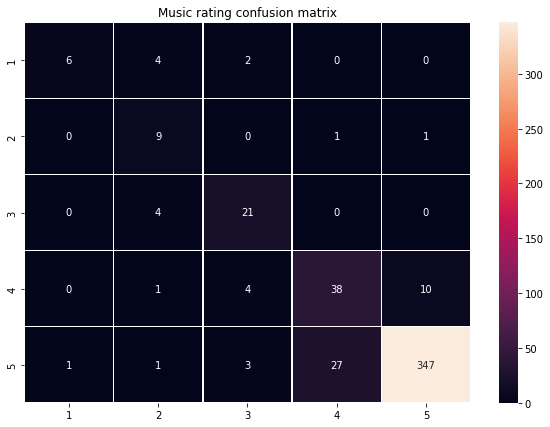

In [15]:
df_drop = df.dropna()
df_drop = df_drop.astype({'prediction': 'int', 'star_rating': 'int'})
df.to_csv("pred/" + p + ".csv", index=False)

array = confusion_matrix(y_true=df_drop['star_rating'], y_pred=df_drop['prediction'], labels = [1,2,3,4,5])

df_cm = pd.DataFrame(array, index = [i for i in [1,2,3,4,5]],
                  columns = [i for i in [1,2,3,4,5]])

plt.figure(figsize = (10,7))
ax = plt.axes()
sn.heatmap(df_cm, annot=True, fmt="d", linewidths=.5, ax=ax);
ax.set_title(f'{p} rating confusion matrix')
plt.show()

### Subset each product category and make predictions on each of them

Sports has 193318 rows were randomly selected
Sports has 7622 rows for predictions
Finished and saved Sports predictions.


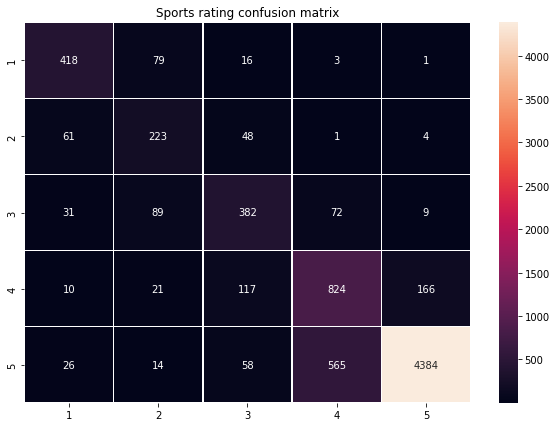

Baby has 69965 rows were randomly selected
Baby has 2831 rows for predictions
Finished and saved Baby predictions.


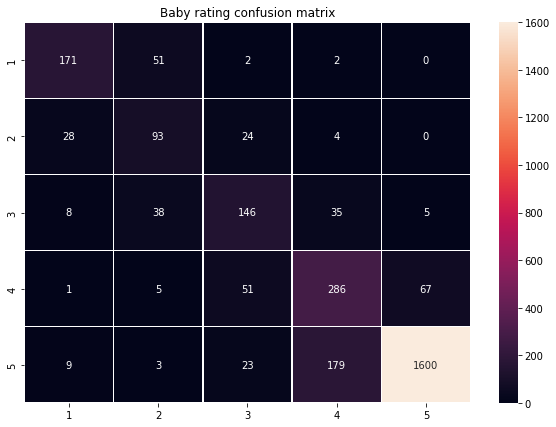

Apparel has 235275 rows were randomly selected
Apparel has 9386 rows for predictions
Finished and saved Apparel predictions.


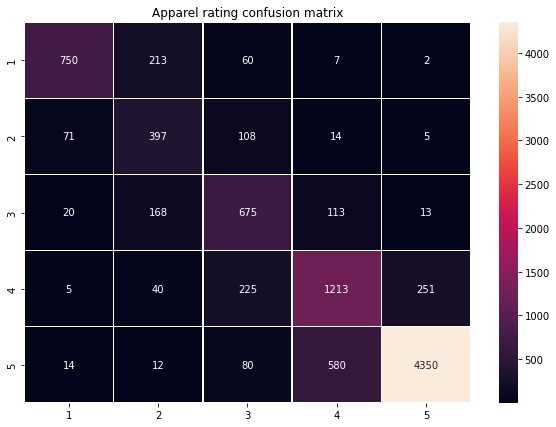

Grocery has 95734 rows were randomly selected
Grocery has 3860 rows for predictions
Finished and saved Grocery predictions.


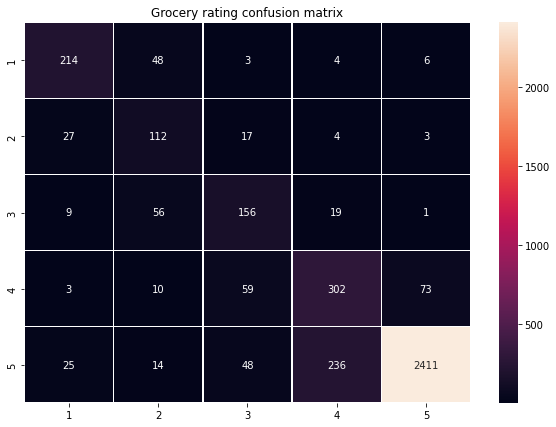

Electronics has 123641 rows were randomly selected
Electronics has 4897 rows for predictions
Finished and saved Electronics predictions.


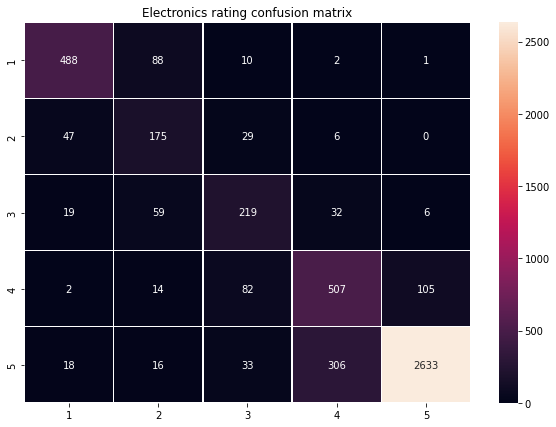

Automotive has 140435 rows were randomly selected
Automotive has 5682 rows for predictions
Finished and saved Automotive predictions.


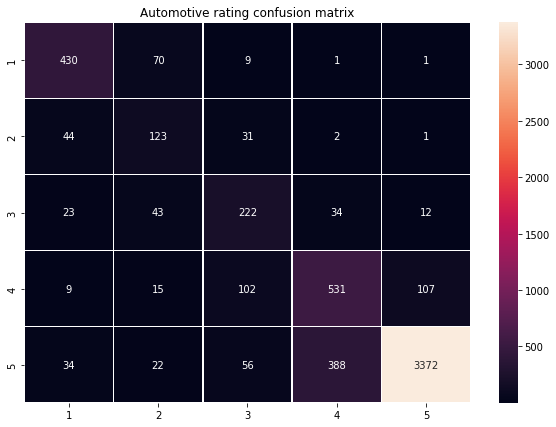

Books has 124215 rows were randomly selected
Books has 4516 rows for predictions
Finished and saved Books predictions.


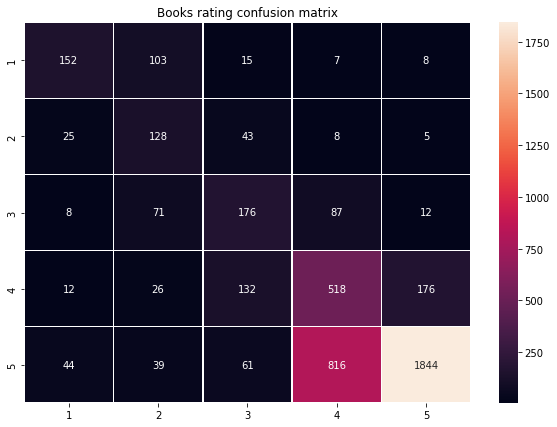

Music has 0 rows were randomly selected
Music has 0 rows for predictions
Finished and saved Music predictions.


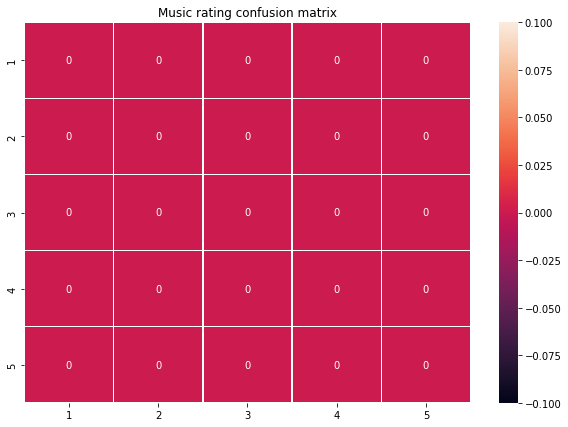

Furniture has 31667 rows were randomly selected
Furniture has 1223 rows for predictions
Finished and saved Furniture predictions.


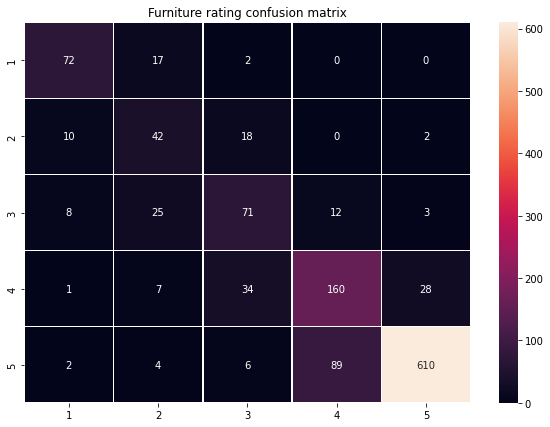

Personal_Care_Appliances has 3437 rows were randomly selected
Personal_Care_Appliances has 125 rows for predictions
Finished and saved Personal_Care_Appliances predictions.


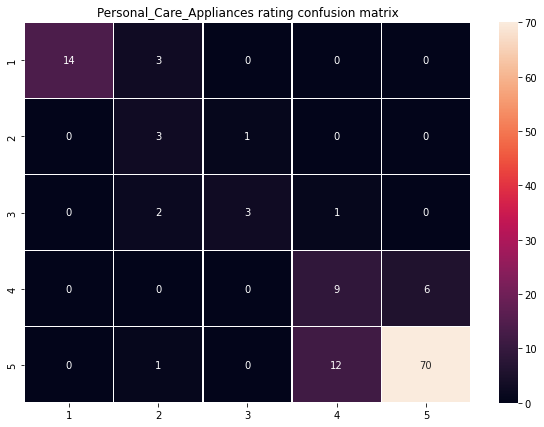

Camera has 72034 rows were randomly selected
Camera has 2989 rows for predictions
Finished and saved Camera predictions.


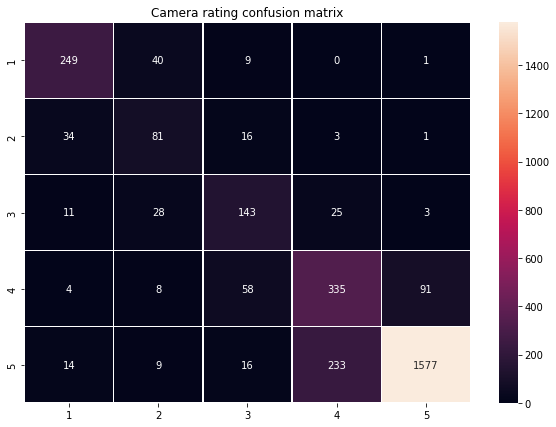

Beauty has 203771 rows were randomly selected
Beauty has 7925 rows for predictions
Finished and saved Beauty predictions.


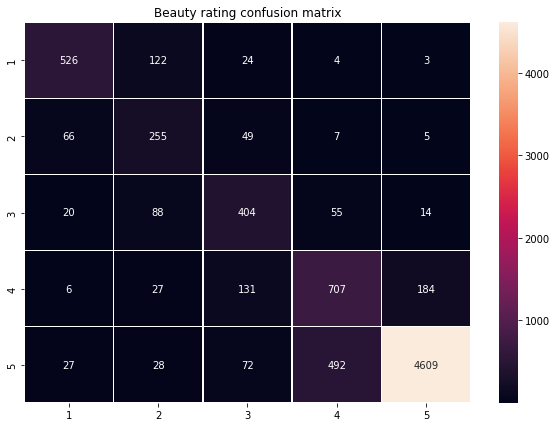

16.924283659458162


In [ ]:
import time
import os
import re

import warnings
warnings.filterwarnings('ignore')

all_files = os.listdir("archive")    
tsv_files = list(filter(lambda f: f.endswith('.tsv'), all_files))

start = time.time()

product_category = ['Sports', 'Baby', 'Apparel', 'Grocery', 'Electronics', 'Automotive', 'Books', 'Music', 'Furniture', 'Personal_Care_Appliances', 'Camera', 'Beauty']

for p in product_category:
  df_name = [i for i in tsv_files if (p in i)][0]
  df = pd.read_csv("archive/" + df_name, sep='\t', error_bad_lines=False, warn_bad_lines=False)
  df = df[df['product_category'] == p]
  df['review'] = df['review_headline'] + ". " + df['review_body']
  df['prediction'] = None
  df = df.sample(frac=0.04)
  print(f'{p} has {df.shape[0]} rows were randomly selected')

  for i in range(df.shape[0]):
    try:
      star = int(specific_model(df.at[i, 'review'])[0]['label'].split(' ')[0])
      df.at[i, 'prediction'] = star
    except:
      pass

  df_drop = df.dropna()
  df_drop = df_drop.astype({'prediction': 'int', 'star_rating': 'int'})
  print(f'{p} has {df_drop.shape[0]} rows for predictions')

  df.to_csv("pred/" + p + ".csv", index=False)
  print(f"Finished and saved {p} predictions.")

  array = confusion_matrix(y_true=df_drop['star_rating'], y_pred=df_drop['prediction'], labels = [1,2,3,4,5])

  df_cm = pd.DataFrame(array, index = [i for i in [1,2,3,4,5]],
                    columns = [i for i in [1,2,3,4,5]])

  plt.figure(figsize = (10,7))
  ax = plt.axes()
  sn.heatmap(df_cm, annot=True, fmt="d", linewidths=.5, ax=ax);
  ax.set_title(f'{p} rating confusion matrix')
  plt.show()

end = time.time()
print((end - start)/60)